# Clasificación de textos en español con CNN

## 1. Preparación del Dataset para extraer la categoría de las noticias


In [2]:
import pandas as pd
from pandasql import sqldf
df = pd.read_csv('data.csv')
print(df.shape)
df.head(4)
# Columnas importantes
ndata = df[['text', 'target_topic']]
data_final = ndata.groupby('target_topic').sample(n=308, random_state=2)
data_final.target_topic.value_counts()
ndata = data_final

q="""SELECT target_topic FROM df GROUP BY target_topic"""
topics=sqldf(q)
topics = topics['target_topic'].to_numpy()
print(topics)

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def process_text(text):
    text = text.lower().replace('\n',' ').replace('\r','').strip()
    text = re.sub(' +', ' ', text)
    text = re.sub(r'[^\w\s]','',text)
    
    
    stop_words = set(stopwords.words('spanish')) 
    word_tokens = word_tokenize(text) 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 
    
    text = " ".join(filtered_sentence)
    return text

ndata['text_parsed'] = ndata['text'].apply(process_text)

from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
print(ndata.target_topic.value_counts())
CNNdata = ndata[['text_parsed', 'target_topic']]
CNNdata['topic_num']= label_encoder.fit_transform(ndata['target_topic'])
#CNNdata = CNNdata[['text_parsed', 'topic_num']]
print("-------")
print(CNNdata.topic_num.value_counts())

from pandasql import sqldf
import numpy as np
from sklearn.model_selection import train_test_split

tdf=CNNdata.loc[CNNdata['topic_num'] == 0]
valid, test, train = np.split(tdf, [int(.15*len(tdf)), int(.3*len(tdf))])
for i in range(1,10):
    tdf=CNNdata.loc[CNNdata['topic_num'] == i]
    tvalid, ttest, ttrain = np.split(tdf, [int(.15*len(tdf)), int(.3*len(tdf))])
    valid=pd.concat([valid, tvalid])
    test=pd.concat([test, ttest])
    train=pd.concat([train, ttrain])

print(CNNdata.shape)
print(train.shape)
print(valid.shape)
print(test.shape)
print(train.topic_num.value_counts())

(8719, 10)
['Catástrofes y Accidentes' 'Ciencias y Tecnologia'
 'Crimen, delitos y justicia' 'Cultura y Artes' 'Deporte' 'Ecologia'
 'Economia' 'Mundo' 'Politica y Conflictos' 'Salud']
Catástrofes y Accidentes      308
Politica y Conflictos         308
Ciencias y Tecnologia         308
Cultura y Artes               308
Economia                      308
Crimen, delitos y justicia    308
Ecologia                      308
Deporte                       308
Mundo                         308
Salud                         308
Name: target_topic, dtype: int64
-------
9    308
7    308
5    308
3    308
1    308
8    308
6    308
4    308
2    308
0    308
Name: topic_num, dtype: int64
(3080, 3)
(2160, 3)
(460, 3)
(460, 3)
9    216
7    216
5    216
3    216
1    216
8    216
6    216
4    216
2    216
0    216
Name: topic_num, dtype: int64


In [3]:
valid = valid.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
train = train.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
test = test.rename(columns={'text_parsed': 'body', 'target_topic': 'category'})
valid = valid[['body', 'category']]
test = test[['body', 'category']]
train = train[['body', 'category']]

Guardaremos los datos en tres archivos CSV: CNN_train, CNN_valid, CNN_test

In [4]:
train.to_csv("CNN_train.csv", encoding="UTF-8",index=False)
valid.to_csv("CNN_valid.csv", encoding="UTF-8",index=False)
test.to_csv("CNN_test.csv", encoding="UTF-8",index=False)

## 2. Clasificar textos según su categoria temática con una red convolucional

**Tarea**: Queremos aprender un modelo capaz de distinguir las noticias según su categoria.

### 2.1 Leer el dataset

In [5]:
import torch
import spacy
import random
import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.legacy import data

In [6]:
#check torch version
import torch
print(torch.__version__) #1.7.0

1.10.0


In [7]:
spacy_es = spacy.load('es_core_news_sm')

In [8]:
def tokenize_es(sentence):
    return [tok.text for tok in spacy_es.tokenizer(sentence)]

In [9]:
print(torch.__version__,spacy.__version__,torchtext.__version__)

1.10.0 3.2.0 0.11.0


In [10]:
TEXT = data.Field(tokenize=tokenize_es, batch_first = True)
CATEGORY = data.LabelField()  # MULTICLASS -se borró el argumento "(dtype = torch.float)"

In [11]:
#fields = [(None, None),(None, None),(None, None),(None, None),('body', TEXT),(None, None),('category', CATEGORY)]
fields = [('body', TEXT),('category', CATEGORY)]

Se leen los CSV para tokenizarlos con Torchtext.data

In [12]:
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_data, valid_data, test_data = data.TabularDataset.splits(
                                        path = '.',
                                        train = 'CNN_train.csv',
                                        validation= 'CNN_valid.csv',
                                        test = 'CNN_test.csv',
                                        format = 'csv',
                                        fields = fields,
                                        skip_header = True
)

In [13]:
BATCH_SIZE = 32

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=lambda x:len(x.category),
    sort_within_batch=False)

cuda


### 2.2 Crear la arquitectura CNN

Empezamos por cargar vectores de palabras para el inglés.

(Para cargar sus propios vectores, por ejemplo para procesor otros idiomas, se puede inspirarse de: https://www.innoq.com/en/blog/handling-german-text-with-torchtext/)

In [14]:
#!wget http://dcc.uchile.cl/~jperez/word-embeddings/glove-sbwc.i25.vec.gz

In [15]:
MAX_VOCAB_SIZE = 50000

## TENER VECTORES EN ESPAÑOL
vec = torchtext.vocab.Vectors('glove-sbwc.i25.vec.gz', cache='.')
TEXT.build_vocab(train_data, vectors=vec, max_size = MAX_VOCAB_SIZE, unk_init = torch.Tensor.normal_)

# TENER VECTORES EN INGLES
# TEXT.build_vocab(train_data, 
#                max_size = MAX_VOCAB_SIZE, 
#                 vectors = "glove.6B.100d", 
#                 unk_init = torch.Tensor.normal_)

CATEGORY.build_vocab(train_data)

In [16]:
print(CATEGORY.vocab.stoi)

defaultdict(None, {'Catástrofes y Accidentes': 0, 'Ciencias y Tecnologia': 1, 'Crimen, delitos y justicia': 2, 'Cultura y Artes': 3, 'Deporte': 4, 'Ecologia': 5, 'Economia': 6, 'Mundo': 7, 'Politica y Conflictos': 8, 'Salud': 9})


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
       
    
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        #text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        return self.fc(cat)

In [18]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300
N_FILTERS = 100
FILTER_SIZES = [1,2,3,4]
OUTPUT_DIM = len(CATEGORY.vocab) ##### MULTICLASS ---> la dimensión del output no es 1 (clasificación binaria)
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [19]:
OUTPUT_DIM

10

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 13,847,610 trainable parameters


In [21]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

### 2.3 Funciones para optimizar el modelo

In [22]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss() #MULTICLASS ---> en lugar de .BCEWithLogitsLoss() (Binary Cross Entropy)

model = model.to(device)
criterion = criterion.to(device)

In [23]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        #print("Tamaño texto de entrada:"+str(batch.body.shape))
        
        predictions = model(batch.body)
        
        #print("Tamaño predecciones de salida:"+str(predictions.shape)) 
        
        #print("Tamaño target:"+str(batch.category.shape)) 
        
        loss = criterion(predictions, batch.category)
        
        acc = categorical_accuracy(predictions, batch.category)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [24]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 2.4 Funciones para evaluar el modelo

In [25]:
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.cuda.FloatTensor([y.shape[0]])

In [26]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.body)
            
            loss = criterion(predictions, batch.category)
            
            acc = categorical_accuracy(predictions, batch.category)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)




### 2.5 Optimización del modelo

In [36]:
print("inicio optimización")

N_EPOCHS = 5 #5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        name = './tematic-model-CNN'+'_ep'+str(epoch+1)+'.pt'
        torch.save({'epoca': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'Valid_loss': best_valid_loss}, name)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



inicio optimización
Epoch: 01 | Epoch Time: 0m 7s
	Train Loss: 0.022 | Train Acc: 99.63%
	 Val. Loss: 0.898 |  Val. Acc: 76.81%
Epoch: 02 | Epoch Time: 0m 8s
	Train Loss: 0.036 | Train Acc: 99.31%
	 Val. Loss: 0.845 |  Val. Acc: 79.31%
Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.027 | Train Acc: 99.54%
	 Val. Loss: 0.885 |  Val. Acc: 76.46%
Epoch: 04 | Epoch Time: 0m 8s
	Train Loss: 0.022 | Train Acc: 99.54%
	 Val. Loss: 0.859 |  Val. Acc: 78.06%
Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.024 | Train Acc: 99.59%
	 Val. Loss: 0.842 |  Val. Acc: 78.40%


### 2.6 Evaluación del modelo

In [37]:
best_model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [41]:
pretrained_embeddings = TEXT.vocab.vectors
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

best_model.embedding.weight.data.copy_(pretrained_embeddings)
best_model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
best_model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [68]:
name = './tematic-model-CNN'+'_ep'+str(2)+'.pt'
best_model.load_state_dict(torch.load(name, map_location=torch.device('cpu'))['model_state_dict'])

<All keys matched successfully>

In [66]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.848 | Test Acc: 78.82%


In [44]:
prediction_test = []
labels_test=[]
for batch in test_iterator:
    labels_test.append(batch.category.cpu().detach().numpy())
    predictions = best_model(batch.body.cpu()).squeeze(1)
    #print(torch.sigmoid(predictions))
    rounded_preds = torch.round(torch.sigmoid(predictions))
    prediction_test.append(rounded_preds.detach().numpy())
    #print(prediction_test)
    

y_true = np.concatenate(labels_test)
y_pred = np.concatenate(prediction_test)

In [45]:

print(y_true.shape)
print(y_pred.shape)
print(y_true[0:5])
print(y_pred[0:5])

(460,)
(460, 10)
[7 7 7 7 7]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]]


## 2.7 Hacer predicciones con el modelo

In [47]:
def predict_class(model, sentence, min_len = 4):

    tokenized = [tok.text for tok in spacy_es.tokenizer(sentence)]
    
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    
    print(indexed)
    #indexed2 = [[0, 0, 1382, 0, 102, 72, 0, 297, 0],[0, 0, 1382, 0, 102, 72, 0, 297, 0]]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    
    preds = model(tensor)
    max_preds = preds.argmax(dim = 1)
    return max_preds.item()

In [50]:
from torchtext import data

pred_class = predict_class(model, "Futbol, pelota golazo de sanchez")
print('Predicted class is: ', pred_class)
#print(f'Predicted class is: {pred_class} = {LABEL.vocab.itos[pred_class]}')

[0, 0, 3367, 8687, 0, 0]
Predicted class is:  4


In [52]:
# Predicting with a test dataset

preds = torch.zeros(test.shape[0])
category = torch.zeros(test.shape[0])
n=0
for batch in test_iterator:
    predictions = model(batch.body)
    max_preds = predictions.argmax(axis=1)
    #print(batch.category.shape)
    #print(max_preds.shape[0])
    if(max_preds.shape[0] == 16):
        n= n + 16
        preds[n-16:n] = max_preds
        category[n-16:n] = batch.category
    else:
        n = n + 32
        preds[n-32:n] = max_preds
        category[n-32:n] = batch.category
    #print(predictions.shape)


Accuracy:  0.782608695652174


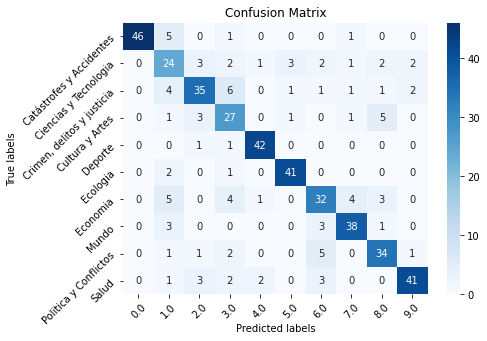

In [53]:
# Predicting with a test dataset
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

#predicted = model1.predict(X_test)
print('Accuracy: ', accuracy_score(preds, category))
#print(classification_report(y_test, predicted))

confusion_matrix = pd.crosstab(preds, category)

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(121)

sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 

ax.set_title('Confusion Matrix'); 

#ax.xaxis.set_ticklabels(topics); 
ax.yaxis.set_ticklabels(topics);

plt.xticks(rotation=45)
plt.yticks(rotation=45)
None

In [ ]:
a=torch.zeros(10)
a[0:5] = torch.Tensor([1,2,3,4,5])
a